In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import json
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:1')

# Data

In [3]:
data_dir = 'log'
dataset_json = 'dataset.json'
data_len = 10000

In [12]:
# Produce dataset_json
n = 0
dataset_paths = []
for i in range(15000):
    if os.path.exists(os.path.join(data_dir, str(i))):
        dataset_paths.append(i)
        n += 1
    if n >= data_len:
        break

with open(os.path.join(data_dir, dataset_json), 'w') as f:
    json.dump({'dataset_paths': dataset_paths}, f, indent=4)

Note: Training seems to be CPU bound - could try preloading all the data into memory if it's small enough. Alternatively, reduce the batch size.

In [9]:
class ClothSimDataset(Dataset):
    """Simulated cloth parameters dataset."""

    def __init__(self, data_dir, dataset_json, transform=None):
        """
        Args:
            data_dir (string): Directory with all the data.
            data_len (int): Name of the json file with dataset information.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        with open(os.path.join(data_dir, dataset_json)) as f:
            dataset_paths = json.load(f)['dataset_paths']
        self.samples = [self.load_sample(os.path.join(data_dir, str(path))) for path in dataset_paths]
    
    def load_sample(self, sample_dir):
        # cloth_points = np.load(os.path.join(sample_dir, 'joint_angles.npy'))
        cloth_points = np.load(os.path.join(sample_dir, 'cloth_points_transformed.npy'))
        parameters = np.load(os.path.join(sample_dir, 'parameters.npy'))
        return cloth_points, parameters
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.samples[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [10]:
def transform(sample):
    cloth_points, params = sample
    # Log spring_damper_time_constant
    params[0] = np.log(params[0])
    # Scale tendon_stiffness
    params[3] *= 10
    # TODO: Augmentations
    # Random crop to 150
    # k = int(np.random.random() * 50)
    k = 0 # 10
    cloth_points = cloth_points[k:k+150]
    return cloth_points, params

In [11]:
train_split = 0.8
train_length = int(train_split * data_len)
val_length = data_len - train_length
all_dataset = ClothSimDataset(data_dir, dataset_json, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_length, val_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True, num_workers=4)

In [12]:
for pts, params in train_loader:
    print(pts.shape)
    print(params.shape)
    break

torch.Size([32, 150, 5, 2])
torch.Size([32, 6])


# Model

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, (3, 3))
        self.conv2 = nn.Conv2d(64, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (1, 5))
        self.conv4 = nn.Conv2d(128, 128, (1, 5))
        self.conv5 = nn.Conv2d(128, 256, (1, 5))
        self.conv6 = nn.Conv2d(256, 256, (1, 5))
        self.pool = nn.MaxPool2d((1, 2), (1, 2))
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(256 * 18, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 6)

    def forward(self, x):
        x = torch.permute(x, (0, 3, 2, 1))
        # (batch, 2, 5, 200)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        # (batch, 64, 1, 98)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        # (batch, 128, 1, 45)
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        # (batch, 256, 1, 18)
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 32, 7, stride=3)
        self.conv2 = nn.Conv1d(32, 64, 5, stride=1)
        self.conv3 = nn.Conv1d(64, 128, 3, stride=1)
        self.conv4 = nn.Conv1d(128, 128, 3, stride=1)
        self.conv5 = nn.Conv1d(128, 128, 3, stride=1)
        self.pool = nn.MaxPool1d(3, stride=2)
        self.dropout = nn.Dropout(0.1)
        self.activation = nn.SiLU()
        self.fc1 = nn.Linear(128, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 2 * 6)

    def forward(self, x):
#         x = torch.permute(x, (0, 3, 2, 1))
        # (batch, 2, 5, 200)
#         x = torch.reshape(x, (-1, 10, 150))
        x = torch.permute(x, (0, 2, 1))
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.activation(self.conv5(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.batchNorm = nn.BatchNorm2d(2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(1500, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 2 * 6)

    def forward(self, x):
#         x = torch.permute(x, (0, 3, 2, 1))
        # (batch, 2, 5, 200)
        # x = self.batchNorm(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [22]:
model = Net().to(device)

# Training

In [85]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.GaussianNLLLoss()
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(500):
    model.train()
    train_losses = []
    for position, target_params in train_loader:
        position = position.to(device).float()
        target_params = target_params.to(device).float()
        
        pred_params_mu, pred_params_logvar = torch.split(model(position), 6, dim=1)
        loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))
#         pred_params = model(position)
#         loss = loss_fn(pred_params, target_params)
        
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for position, target_params in val_loader:
            position = position.to(device).float()
            target_params = target_params.to(device).float()

            pred_params_mu, pred_params_logvar = torch.split(model(position), 6, dim=1)
            loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))
#             pred_params = model(position)
#             loss = loss_fn(pred_params, target_params)

            val_losses.append(loss.item())

    print("Epoch: {}, Train Loss: {}, Val Loss: {}".format(epoch, np.mean(train_losses), np.mean(val_losses)))
    epoch_train_losses.append(np.mean(train_losses))
    epoch_val_losses.append(np.mean(val_losses))

Epoch: 0, Train Loss: 0.21679564514756203, Val Loss: 0.1018994805358705
Epoch: 1, Train Loss: 0.04795926822721958, Val Loss: 0.0369684174065552
Epoch: 2, Train Loss: 0.03602669283747673, Val Loss: 0.03594026821000235
Epoch: 3, Train Loss: 0.03554555212706328, Val Loss: 0.035669993402229414
Epoch: 4, Train Loss: 0.03552731765061617, Val Loss: 0.03566940371242781
Epoch: 5, Train Loss: 0.03547124193608761, Val Loss: 0.03563328536729964
Epoch: 6, Train Loss: 0.03548634845763445, Val Loss: 0.03559512065516578
Epoch: 7, Train Loss: 0.035487971112132075, Val Loss: 0.03555209828274591
Epoch: 8, Train Loss: 0.03542105563730001, Val Loss: 0.03563276595539517
Epoch: 9, Train Loss: 0.03544110172241926, Val Loss: 0.035557366878030794
Epoch: 10, Train Loss: 0.03544657012820244, Val Loss: 0.035646582288401465
Epoch: 11, Train Loss: 0.03539647915959358, Val Loss: 0.0355662585250915
Epoch: 12, Train Loss: 0.03533182033151388, Val Loss: 0.03556331797015099
Epoch: 13, Train Loss: 0.03530934326350689, Val

Epoch: 110, Train Loss: 0.023382183134555815, Val Loss: 0.023928498701443746
Epoch: 111, Train Loss: 0.0233770055398345, Val Loss: 0.023906979857692644
Epoch: 112, Train Loss: 0.023354918479919433, Val Loss: 0.02390458236729342
Epoch: 113, Train Loss: 0.023330030985176563, Val Loss: 0.023907115594262167
Epoch: 114, Train Loss: 0.02334356663376093, Val Loss: 0.023875781793206458
Epoch: 115, Train Loss: 0.023323530964553356, Val Loss: 0.023880185470694586
Epoch: 116, Train Loss: 0.023294346913695335, Val Loss: 0.023859716301399565
Epoch: 117, Train Loss: 0.02328594943881035, Val Loss: 0.02382549430642809
Epoch: 118, Train Loss: 0.023273233704268932, Val Loss: 0.0238175562154206
Epoch: 119, Train Loss: 0.023266232021152973, Val Loss: 0.02384394265356518
Epoch: 120, Train Loss: 0.023242437362670898, Val Loss: 0.023807938905462386
Epoch: 121, Train Loss: 0.023244905941188335, Val Loss: 0.023847103444120242
Epoch: 122, Train Loss: 0.02320045643299818, Val Loss: 0.02381970023825055
Epoch: 123

Epoch: 218, Train Loss: 0.02125199121236801, Val Loss: 0.02186653467397841
Epoch: 219, Train Loss: 0.021229694098234178, Val Loss: 0.021843570801946852
Epoch: 220, Train Loss: 0.021215384796261786, Val Loss: 0.02187722581364806
Epoch: 221, Train Loss: 0.02122132404893637, Val Loss: 0.021869508342610464
Epoch: 222, Train Loss: 0.02121226565539837, Val Loss: 0.021854043746041874
Epoch: 223, Train Loss: 0.02118059601634741, Val Loss: 0.021829208388688074
Epoch: 224, Train Loss: 0.021180543959140777, Val Loss: 0.021802061577401464
Epoch: 225, Train Loss: 0.021173080436885358, Val Loss: 0.021864317239276947
Epoch: 226, Train Loss: 0.02112855713814497, Val Loss: 0.021781360789660423
Epoch: 227, Train Loss: 0.021140465334057806, Val Loss: 0.021827033321772302
Epoch: 228, Train Loss: 0.021141342356801034, Val Loss: 0.021771100778428334
Epoch: 229, Train Loss: 0.02110091270506382, Val Loss: 0.02175767385652141
Epoch: 230, Train Loss: 0.021098192252218723, Val Loss: 0.02172716325592427
Epoch: 23

Epoch: 326, Train Loss: 0.020191628336906433, Val Loss: 0.020820195505779886
Epoch: 327, Train Loss: 0.02020620412006974, Val Loss: 0.020827523950073455
Epoch: 328, Train Loss: 0.0202105422988534, Val Loss: 0.020800134699259485
Epoch: 329, Train Loss: 0.02017990366369486, Val Loss: 0.02080985770693847
Epoch: 330, Train Loss: 0.020175499331206083, Val Loss: 0.020850573503781878
Epoch: 331, Train Loss: 0.020163309879601, Val Loss: 0.020920377135986372
Epoch: 332, Train Loss: 0.020137317448854445, Val Loss: 0.02079941604345564
Epoch: 333, Train Loss: 0.02015881073474884, Val Loss: 0.02081688106178291
Epoch: 334, Train Loss: 0.02013536899536848, Val Loss: 0.02082688816719585
Epoch: 335, Train Loss: 0.02015893155708909, Val Loss: 0.020761107818947896
Epoch: 336, Train Loss: 0.02012306210398674, Val Loss: 0.020883754782733462
Epoch: 337, Train Loss: 0.020154932945966722, Val Loss: 0.020757762212601918
Epoch: 338, Train Loss: 0.02012091786786914, Val Loss: 0.020752943579166655
Epoch: 339, Tra

Epoch: 434, Train Loss: 0.019705231145024298, Val Loss: 0.020337210702044622
Epoch: 435, Train Loss: 0.019716062862426043, Val Loss: 0.020415882092146648
Epoch: 436, Train Loss: 0.01968511263281107, Val Loss: 0.020373528143243183
Epoch: 437, Train Loss: 0.01969240854680538, Val Loss: 0.020356427198128094
Epoch: 438, Train Loss: 0.019668528076261283, Val Loss: 0.02033337347564243
Epoch: 439, Train Loss: 0.019687837615609168, Val Loss: 0.020312878998026015
Epoch: 440, Train Loss: 0.01970125022530556, Val Loss: 0.02030286689599355
Epoch: 441, Train Loss: 0.01965828290209174, Val Loss: 0.02046931857272746
Epoch: 442, Train Loss: 0.01965878043696284, Val Loss: 0.02034318692509144
Epoch: 443, Train Loss: 0.019647445667535065, Val Loss: 0.020310359046099676
Epoch: 444, Train Loss: 0.019640009097754957, Val Loss: 0.020348268989769238
Epoch: 445, Train Loss: 0.01966239084303379, Val Loss: 0.02039063914072892
Epoch: 446, Train Loss: 0.01966686099767685, Val Loss: 0.020345695819410068
Epoch: 447,

In [52]:
torch.save(model.state_dict(), 'AlexNet-Angle-500-Clipped10-GaussianLoss-1e-5')

In [49]:
epoch_train_losses_1 = epoch_train_losses
epoch_val_losses_1 = epoch_val_losses

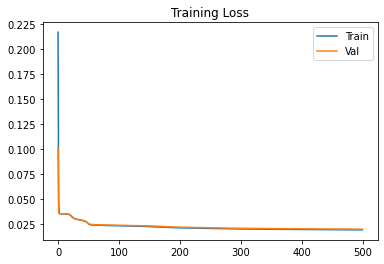

In [86]:
plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)
plt.legend(["Train", "Val"])
plt.title("Training Loss")
plt.show()

# Eyeball Results

In [87]:
for position, target_params in val_loader:
#     prediction = model(position.to(device).float())
    pred_params_mu, pred_params_logvar = torch.split(model(position.to(device).float()), 6, dim=1)
    prediction = pred_params_mu
    r = prediction.detach().cpu() - target_params
    break
print(torch.mean(r, axis=0))
print(torch.std(r, axis=0))

tensor([-0.0088, -0.0780,  0.1418,  0.0033,  0.0514,  0.0021],
       dtype=torch.float64)
tensor([0.0560, 0.2993, 0.2533, 0.0578, 0.2702, 0.0392], dtype=torch.float64)


# Inference

In [23]:
model.load_state_dict(torch.load('FCNet-19-Clipped-GaussianLoss-1e-5'))

<All keys matched successfully>

In [24]:
recorded_positions = np.load('data/scaled_recorded_cloth_points.npy')

## Using Cloth Positions

In [38]:
# Rescale and save
recorded_positions = torch.as_tensor(recorded_positions).unsqueeze(0)
pred_params, _ = torch.split(model(recorded_positions.to(device).float()), 6, dim=1)
pred_params = pred_params.detach().cpu().numpy().squeeze()
pred_params[0] = np.exp(pred_params[0])
pred_params[3] /= 10
print(pred_params)
np.save('pred_params', pred_params)

[0.07699788 1.8899841  1.7827961  0.17709634 1.749825   1.7384199 ]


## Using Joint Angles

Use joint angles instead

In [89]:
def qpos_2d(a, b, c, eps=1e-9):
    u, v = a - b, c - b
    u_norm, v_norm = np.linalg.norm(u) + eps, np.linalg.norm(v) + eps
    phi = np.arccos(np.dot(u, v) / u_norm / v_norm)
    th = np.pi - phi
    u_hat, v_hat = np.block([u, 0]), np.block([v, 0])
    w = np.cross(u_hat, v_hat)
    th *= -1 if w[-1] > 0 else 1
    return th

In [90]:
h, c, _ = recorded_positions.shape
joint_angles = np.zeros((h, c - 2))
for i in range(h):
    for j in range(c - 2):
        p1, p2, p3 = recorded_positions[i, j], recorded_positions[i, j + 1], recorded_positions[i, j + 2]
        joint_angles[i, j] = qpos_2d(p1, p2, p3)

In [91]:
# Rescale and save
recorded_positions = torch.as_tensor(joint_angles).unsqueeze(0)
# pred_params = model(recorded_positions.to(device).float())
pred_params, _ = torch.split(model(recorded_positions.to(device).float()), 6, dim=1)
pred_params = pred_params.detach().cpu().numpy().squeeze()
pred_params[0] = np.exp(pred_params[0])
pred_params[3] /= 10
print(pred_params)
np.save('pred_params', pred_params)

[2.6756399 0.        1.        0.1       0.        0.       ]
